In [34]:
!conda install -c conda-forge yellowbrick -y
!conda install -c conda-forge phik -y
!conda install -c conda-forge imbalanced-learn -y
!conda install -c conda-forge missingno -y
;

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environ

''

# Classification of Bank Marketing Success

## Importing Libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
import phik
sns.set()

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from yellowbrick.model_selection import learning_curve, feature_importances
from sklearn.inspection import permutation_importance

# Data Preprocessing
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler # Deal with Class Imbalance

# Models
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest

# Anomaly Detection
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

## Data Ingestion

In [3]:
bank_df = pd.read_csv("dataset/bank-full.csv", sep=";")
bank_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Data Exploration

In [4]:
bank_eda = bank_df.copy()

In [5]:
bank_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


At first glance, it seems there are no missing values and the data types are correct.

### Investigating The Target Variable

#### What is the prediction target?

<AxesSubplot:xlabel='y', ylabel='count'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


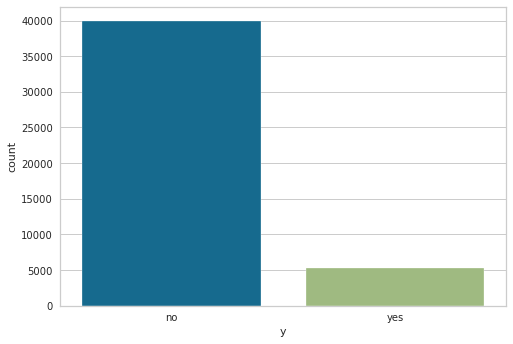

In [7]:
sns.countplot(data=bank_eda, x="y")

We note that the classes are highly imbalanced, with most customers not signing up after marketing. This would suggest a strategy of oversampling may be required to handle imbalanced classes. It also suggests that we could treat the problem as an anomaly detection problem.

### Univariate Analysis

#### Quantitative Variables

In [8]:
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

##### Descriptive Statistics

In [9]:
bank_eda.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


- The middle 50% of all customers are of ages 33 to 48. The oldest customer is 95. This suggests most customers are middle aged, working adults.
- Some customers had a negative balance in their account, but the middle 50% had an average yearly balance of 72 to 1428 euros 
- With the exception of day, most quantitative features had mean values larger than the median, suggesting that their distributions are positively skewed.
- At least 75% of all clients had never been contacted by the bank for any campaigns. At least one client had not been contacted for more than two years.
- Almost all clients had never been contacted before by the bank as the 75% percentile for previous contacts is 0. However, the max of 275 suggests that a few were regular customers of the bank before.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


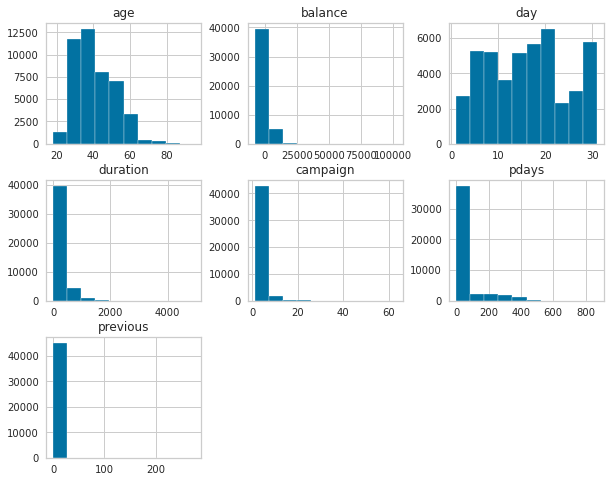

In [10]:
fig = bank_eda[numerical_features].hist(figsize=(10, 8))

We note that with the exception of day, most of the quantitative data has a positively skewed distribution. 


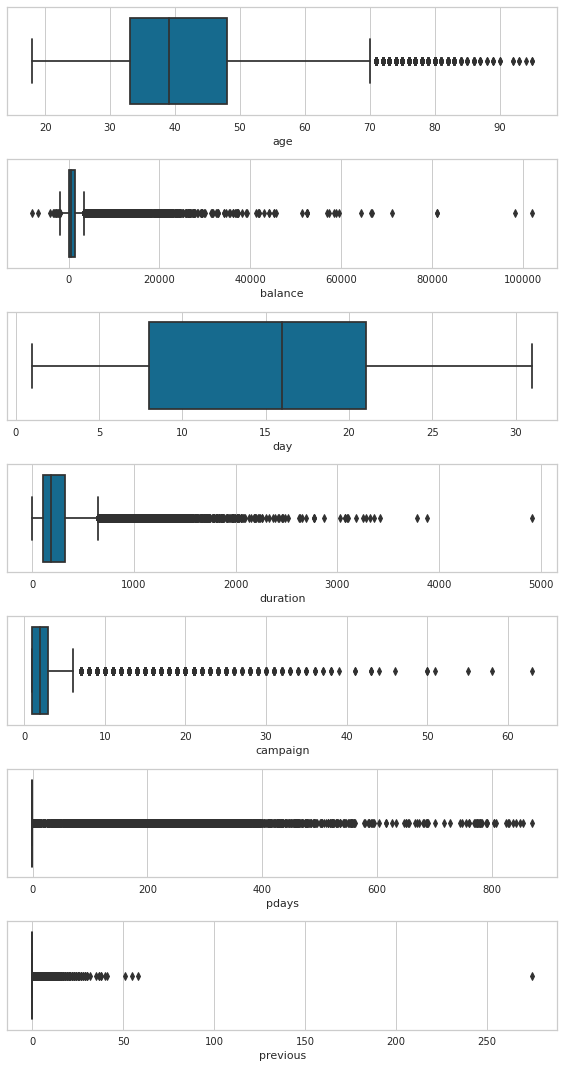

In [14]:
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(numerical_features):
    sns.boxplot(data=bank_eda, x=feature, ax = ax[idx])
fig.show()

- Balance has outliers with negative balance.
- All other columns have outliers that are above the upper quartile.

#### Qualitative Variables

In [15]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [6]:
bank_eda.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


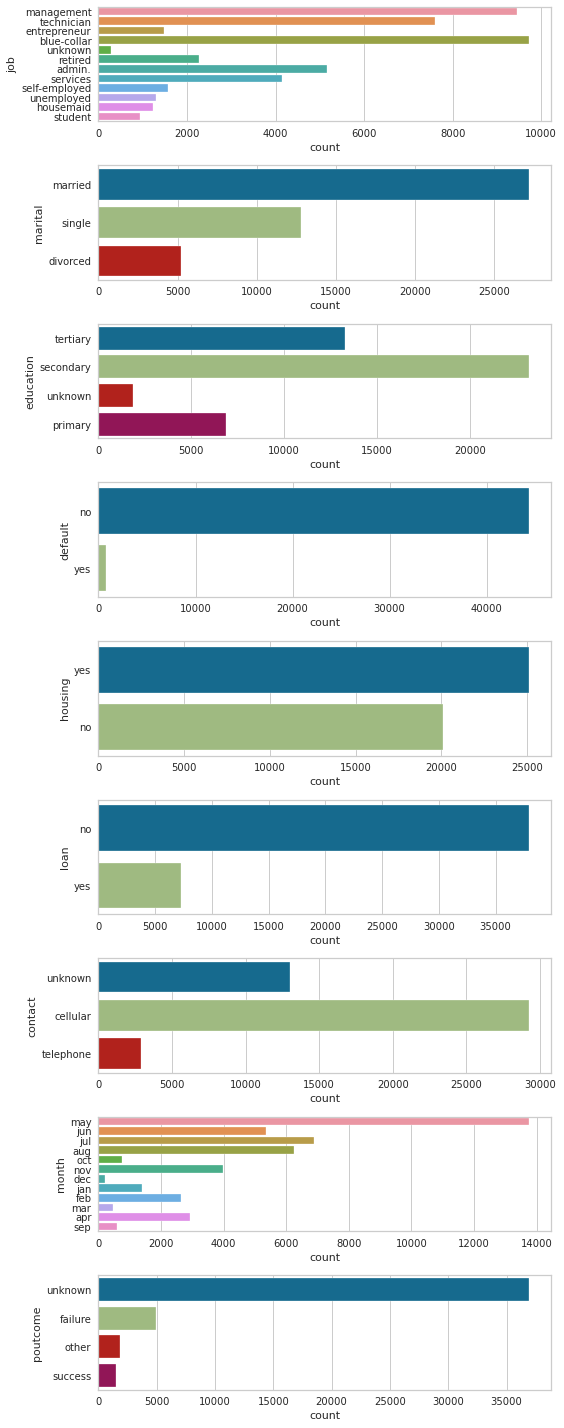

In [19]:
fig, ax = plt.subplots(len(categorical_features), 1, figsize=(8, 20), tight_layout = True)

for idx, feature in enumerate(categorical_features):
    sns.countplot(data=bank_eda, y = feature, ax = ax[idx])
fig.show()

### Investigating Missing Values
In the initial analysis, we found that no values in the data were marked as missing. However, during our EDA, we found that certain categorical variables had values marked as "unknown". 

This suggests that there are missing values in the data. However, to determine what to do with them, we first need to decide if these values are missing at random, or if they are missing for systematic reasons.

#### Types of Missing Data
| Type | Description |
|----|----|
|Missing At Random| Rubin (1978) defined MAR as occuring when "given variables X and Y, the probabilty of response depends on X but not Y"|

In [39]:
bank_eda_na = bank_df = pd.read_csv("dataset/bank-full.csv", sep=";", na_values = {"poutcome": "unknown", "contact" : "unknown", "job" : "unknown", "education" : "unknown", "pdays" : -1})

In [40]:
bank_eda_na.isna().sum().sort_values(ascending=False)

poutcome     36959
pdays        36954
contact      13020
education     1857
job            288
housing          0
marital          0
default          0
balance          0
y                0
loan             0
day              0
month            0
duration         0
campaign         0
previous         0
age              0
dtype: int64

<AxesSubplot:title={'center':'Percentage of Missing Values'}>

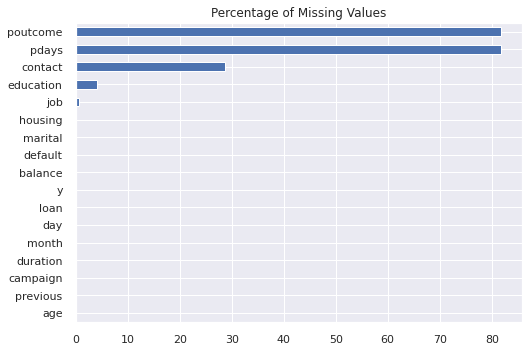

In [41]:
(bank_eda_na.isna().sum().sort_values(ascending=True) / len(bank_eda_na) * 100).plot(kind='barh', title="Percentage of Missing Values")

<AxesSubplot:>

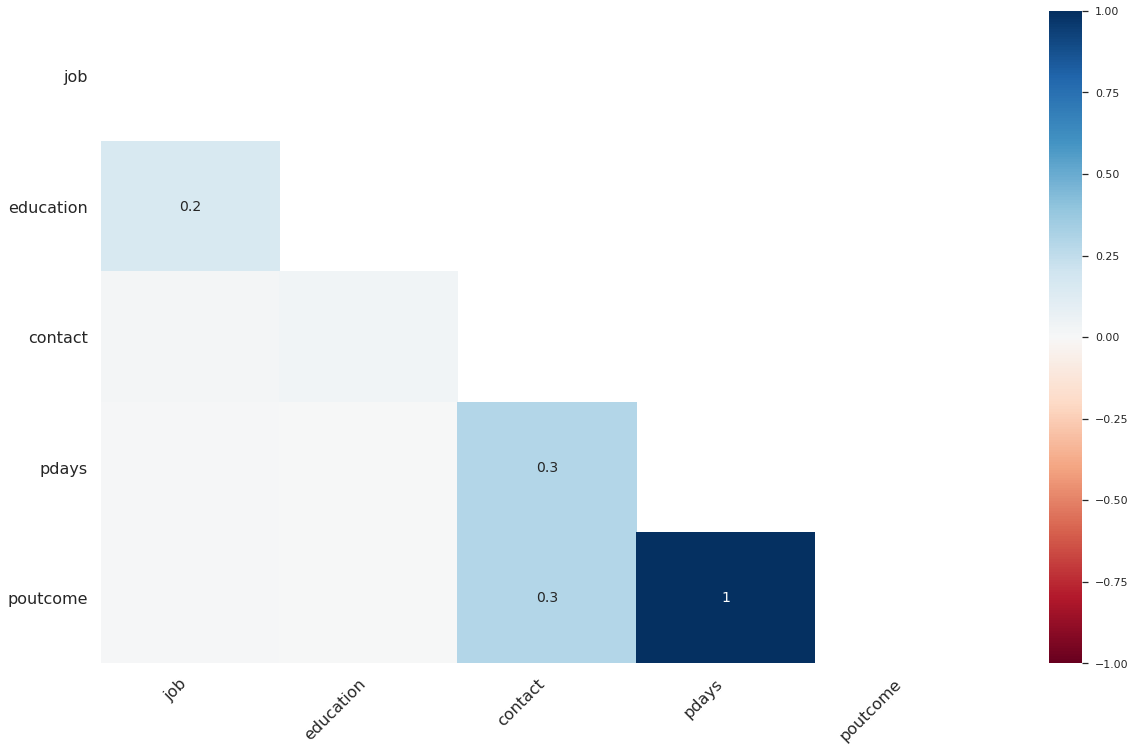

In [42]:
msno.heatmap(bank_eda_na)

It seems that those who had known jobs were more likely to have complete educational data. In addition, those who had a known outcome from a previous campaign were more likely to have a known form of contact. 

We note that there is a 1-1 correlation between a customer never being contacted before and knowing the outcome of the previous campaign. This suggests that missing past outcomes are MNAR (missing not at random). This is logical, as if they are new clients, we would never have contacted them before, and thus have no previous outcomes. Based off this information, it would be best if we kept unknown as an indicator value for `poutcome`.

### Bivariate Analysis

#### Pairplot

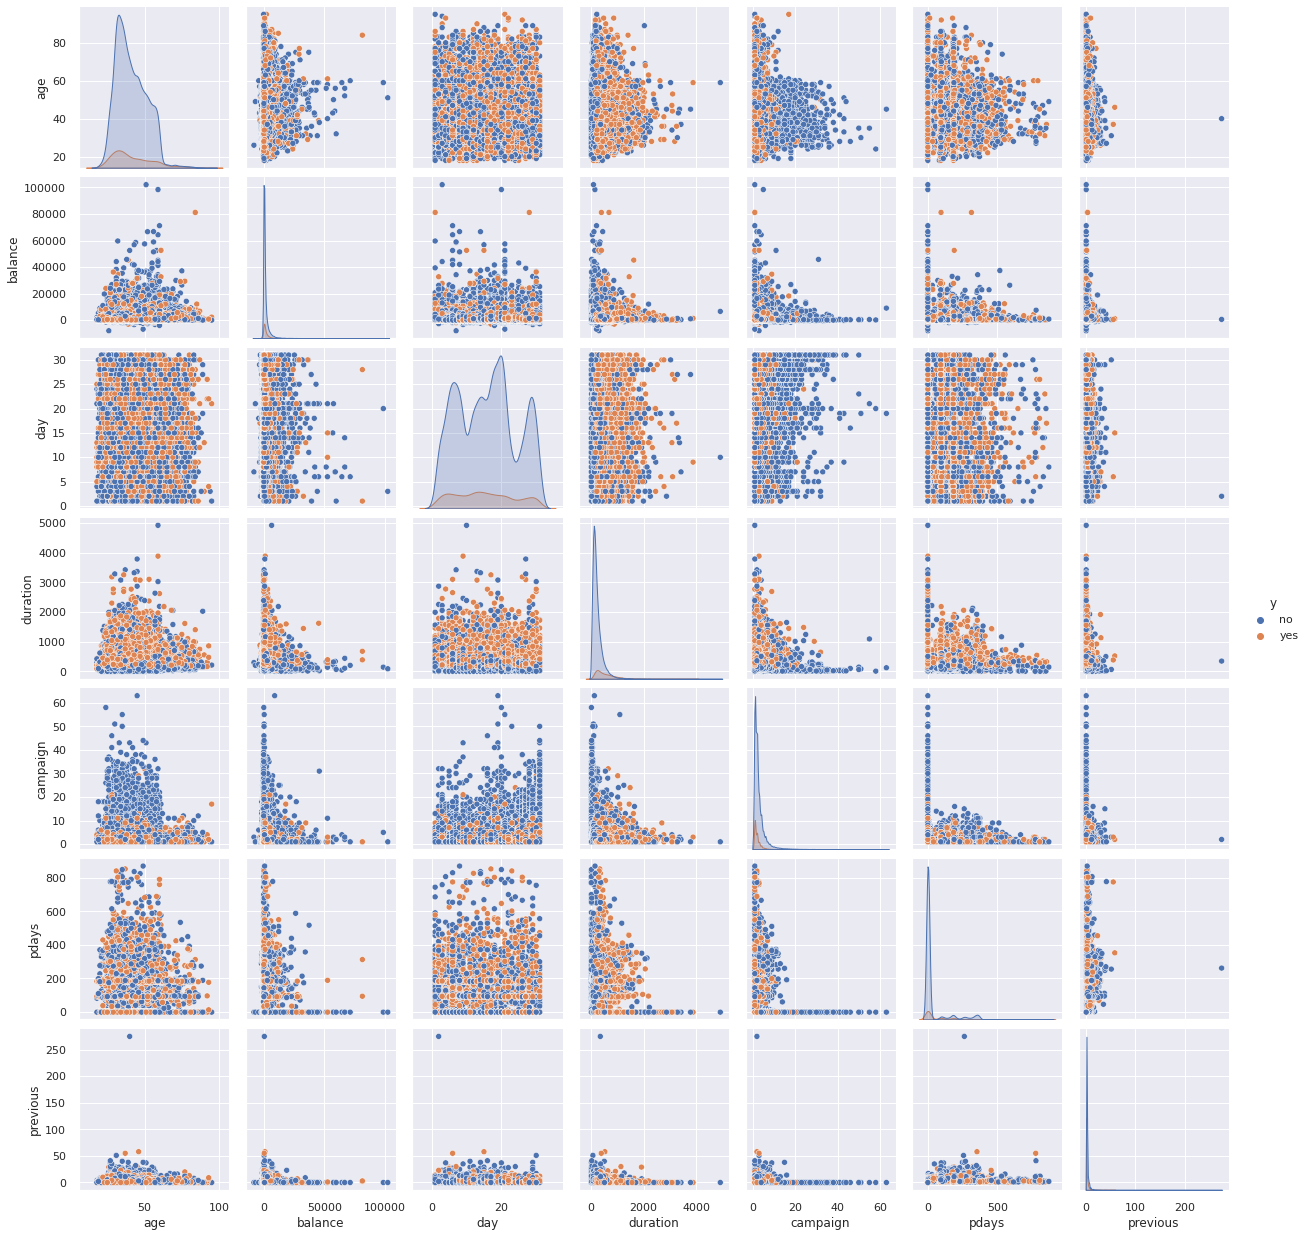

In [56]:
sns.pairplot(bank_eda, hue="y")

#### $\phi_k$ Correlation

<AxesSubplot:>

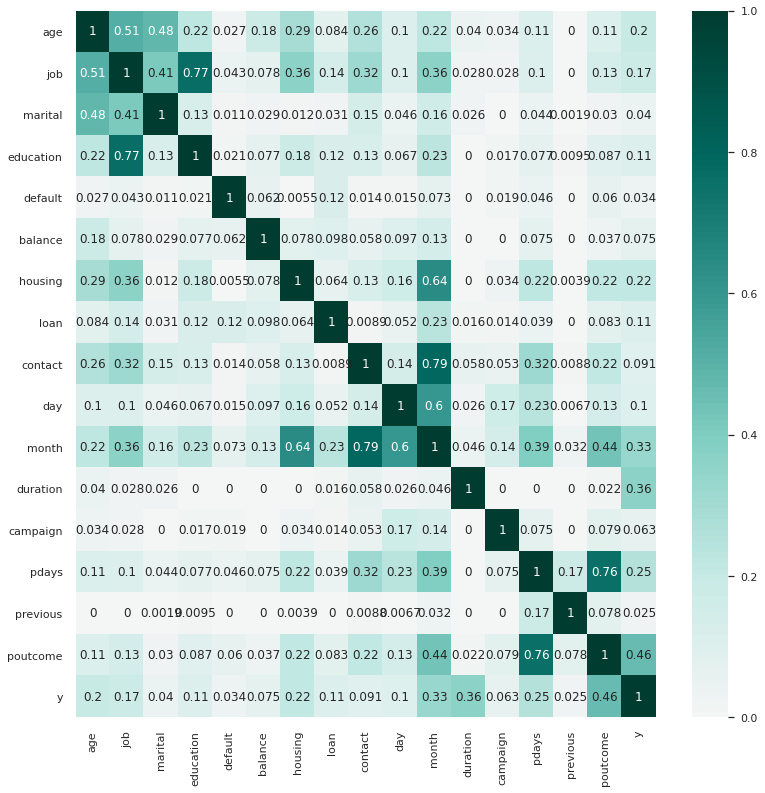

In [54]:
corr_matrix = bank_eda.phik_matrix(interval_cols = numerical_features)
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corr_matrix, annot = True, center = 0, cmap='BrBG')

## Data Preparation

In [95]:
X, y = bank_df.drop('y', axis = 1), bank_df['y']

### Baseline Data Preparation
We start with a baseline data preprocessing pipeline, which does not do anything with missing values, and performs basic scaling for numerical data.

In [28]:
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numerical_transformers = Pipeline([
    ('Robust Scaler', RobustScaler())
])

categorical_transformers = Pipeline([
    ('One Hot Encoder', OneHotEncoder(drop='if_binary'))
])

data_preprocessing = ColumnTransformer([
    ('Preprocess Numerical Features', numerical_transformers, numerical_features),
    ('Preprocess Categorical Features', categorical_transformers, categorical_features)
])

## Data Split
We will split our data to obtain a hold-out test set to evaluate the performance of the final model. Cross Validation will be done on the rest of the data to evaluate various learning algorithms.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y, test_size = .2)

In [24]:
X_train.shape

NameError: name 'X_train' is not defined

## Modelling

### Evaluation 
To standardize the evaluation of our candidate models, we will create a utility function which will do the following things:
1. Obtain a cross validated mean training and validation score of our model
2. Update a history of scores of past candidate models
3. Generate a learning curve of our model to help in evaluating bias and variance
4. If required, return the fitted model.

In [27]:
def evaluate_candidate_model(clf, X, y, metrics, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42), model_name = None, history = pd.DataFrame(), return_estimator = False, return_learning_curve = True):
    model_name = model_name if model_name is None else type(clf).__name__
    single_metric = type(metrics) in { str, callable }
    scores = cross_validate(clf, X, y, cv = cv, scoring = metrics, return_train_score = True, return_estimator = return_estimator)
    if return_estimator:
        best_estimator = scores["estimator"][np.argmax(scores["test_score"]) if single_metric else np.argmax(scores[f"test_{metrics[0]}"])]
        del scores["estimator"]
    scores = pd.DataFrame(scores).describe().iloc[1:3, 2:].round(5) # Get Summarized Cross Val Scores
    history = history.append(pd.DataFrame(scores.iloc[0, :], index = [model_name]))
    learning_curve = learning_curve(clf, X, y, scoring = metrics if single_metric else metrics[0], cv = cv)
    return scores, history, learning_curve, best_estimator if return_estimator else None

### Baseline Model

In [ ]:
scores, history, learning_curve, _ = evaluate_candidate_model()